# Importing Libraries


In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn import model_selection, preprocessing, svm, neighbors
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


# Load Data

In [2]:
path = '/home/vaishu/Machine Learning/task' # use your training files (.csv) path

all_files = glob.glob(path + "/*.csv")
all_files = sorted(all_files)

gen_train_file = all_files[-1]
all_files = all_files[: -1]

gen_df = pd.read_csv(gen_train_file)

li = []

for index, row in gen_df.iterrows():
    df = pd.read_csv(all_files[index])
    
    #input features
    df['feedrate'] = row['feedrate']
    df['clamp_pressure'] = row['clamp_pressure']
    
    #target data
    df['tool_condition'] = row['tool_condition']
    #df['machining_finalized'] = row['machining_finalized']
    #df['passed_visual_inspection'] = row['passed_visual_inspection']
    
    li.append(df)

data_frame = pd.concat(li)
data_frame.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,tool_condition
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,6,4.0,unworn
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,6,4.0,unworn
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,6,4.0,unworn
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,6,4.0,unworn
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,6,4.0,unworn


# Data Preprocessing

In [3]:
def handle_non_numerical_data(df):
    columns = df.columns.values

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

In [4]:
data_frame.replace('?',-99999, inplace=True)
# data_frame = data_frame.astype(float) If editor is other than Jupyter

data_frame = handle_non_numerical_data(data_frame)
data_frame.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,tool_condition
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,0.0,6.960000e-07,12.0,1.0,0.0,50.0,7,6,4.0,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,6,6,4.0,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,0.0,9.100000e-07,12.0,1.0,7.0,50.0,6,6,4.0,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,0.0,1.070000e-06,12.0,1.0,7.0,50.0,6,6,4.0,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,0.0,1.960000e-06,12.0,1.0,7.0,50.0,6,6,4.0,0


# Visualize the Data

In [5]:
print("Feature count")

for i in range(1, len(gen_df.columns)):
    print(gen_df.columns[i])
    print(gen_df.iloc[:,i].value_counts())
    print()


Feature count
material
wax    18
Name: material, dtype: int64

feedrate
3     6
20    5
6     5
15    1
12    1
Name: feedrate, dtype: int64

clamp_pressure
4.0    9
3.0    6
2.5    3
Name: clamp_pressure, dtype: int64

tool_condition
worn      10
unworn     8
Name: tool_condition, dtype: int64

machining_finalized
yes    14
no      4
Name: machining_finalized, dtype: int64

passed_visual_inspection
yes    10
no      4
Name: passed_visual_inspection, dtype: int64



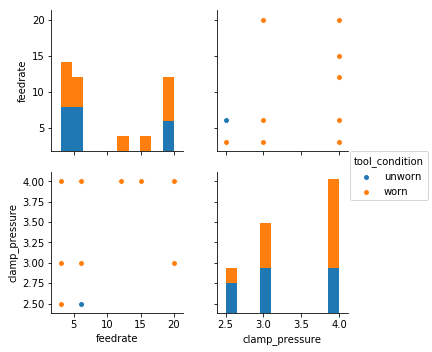

In [6]:
sns.pairplot(gen_df, hue='tool_condition', vars=["feedrate","clamp_pressure"])

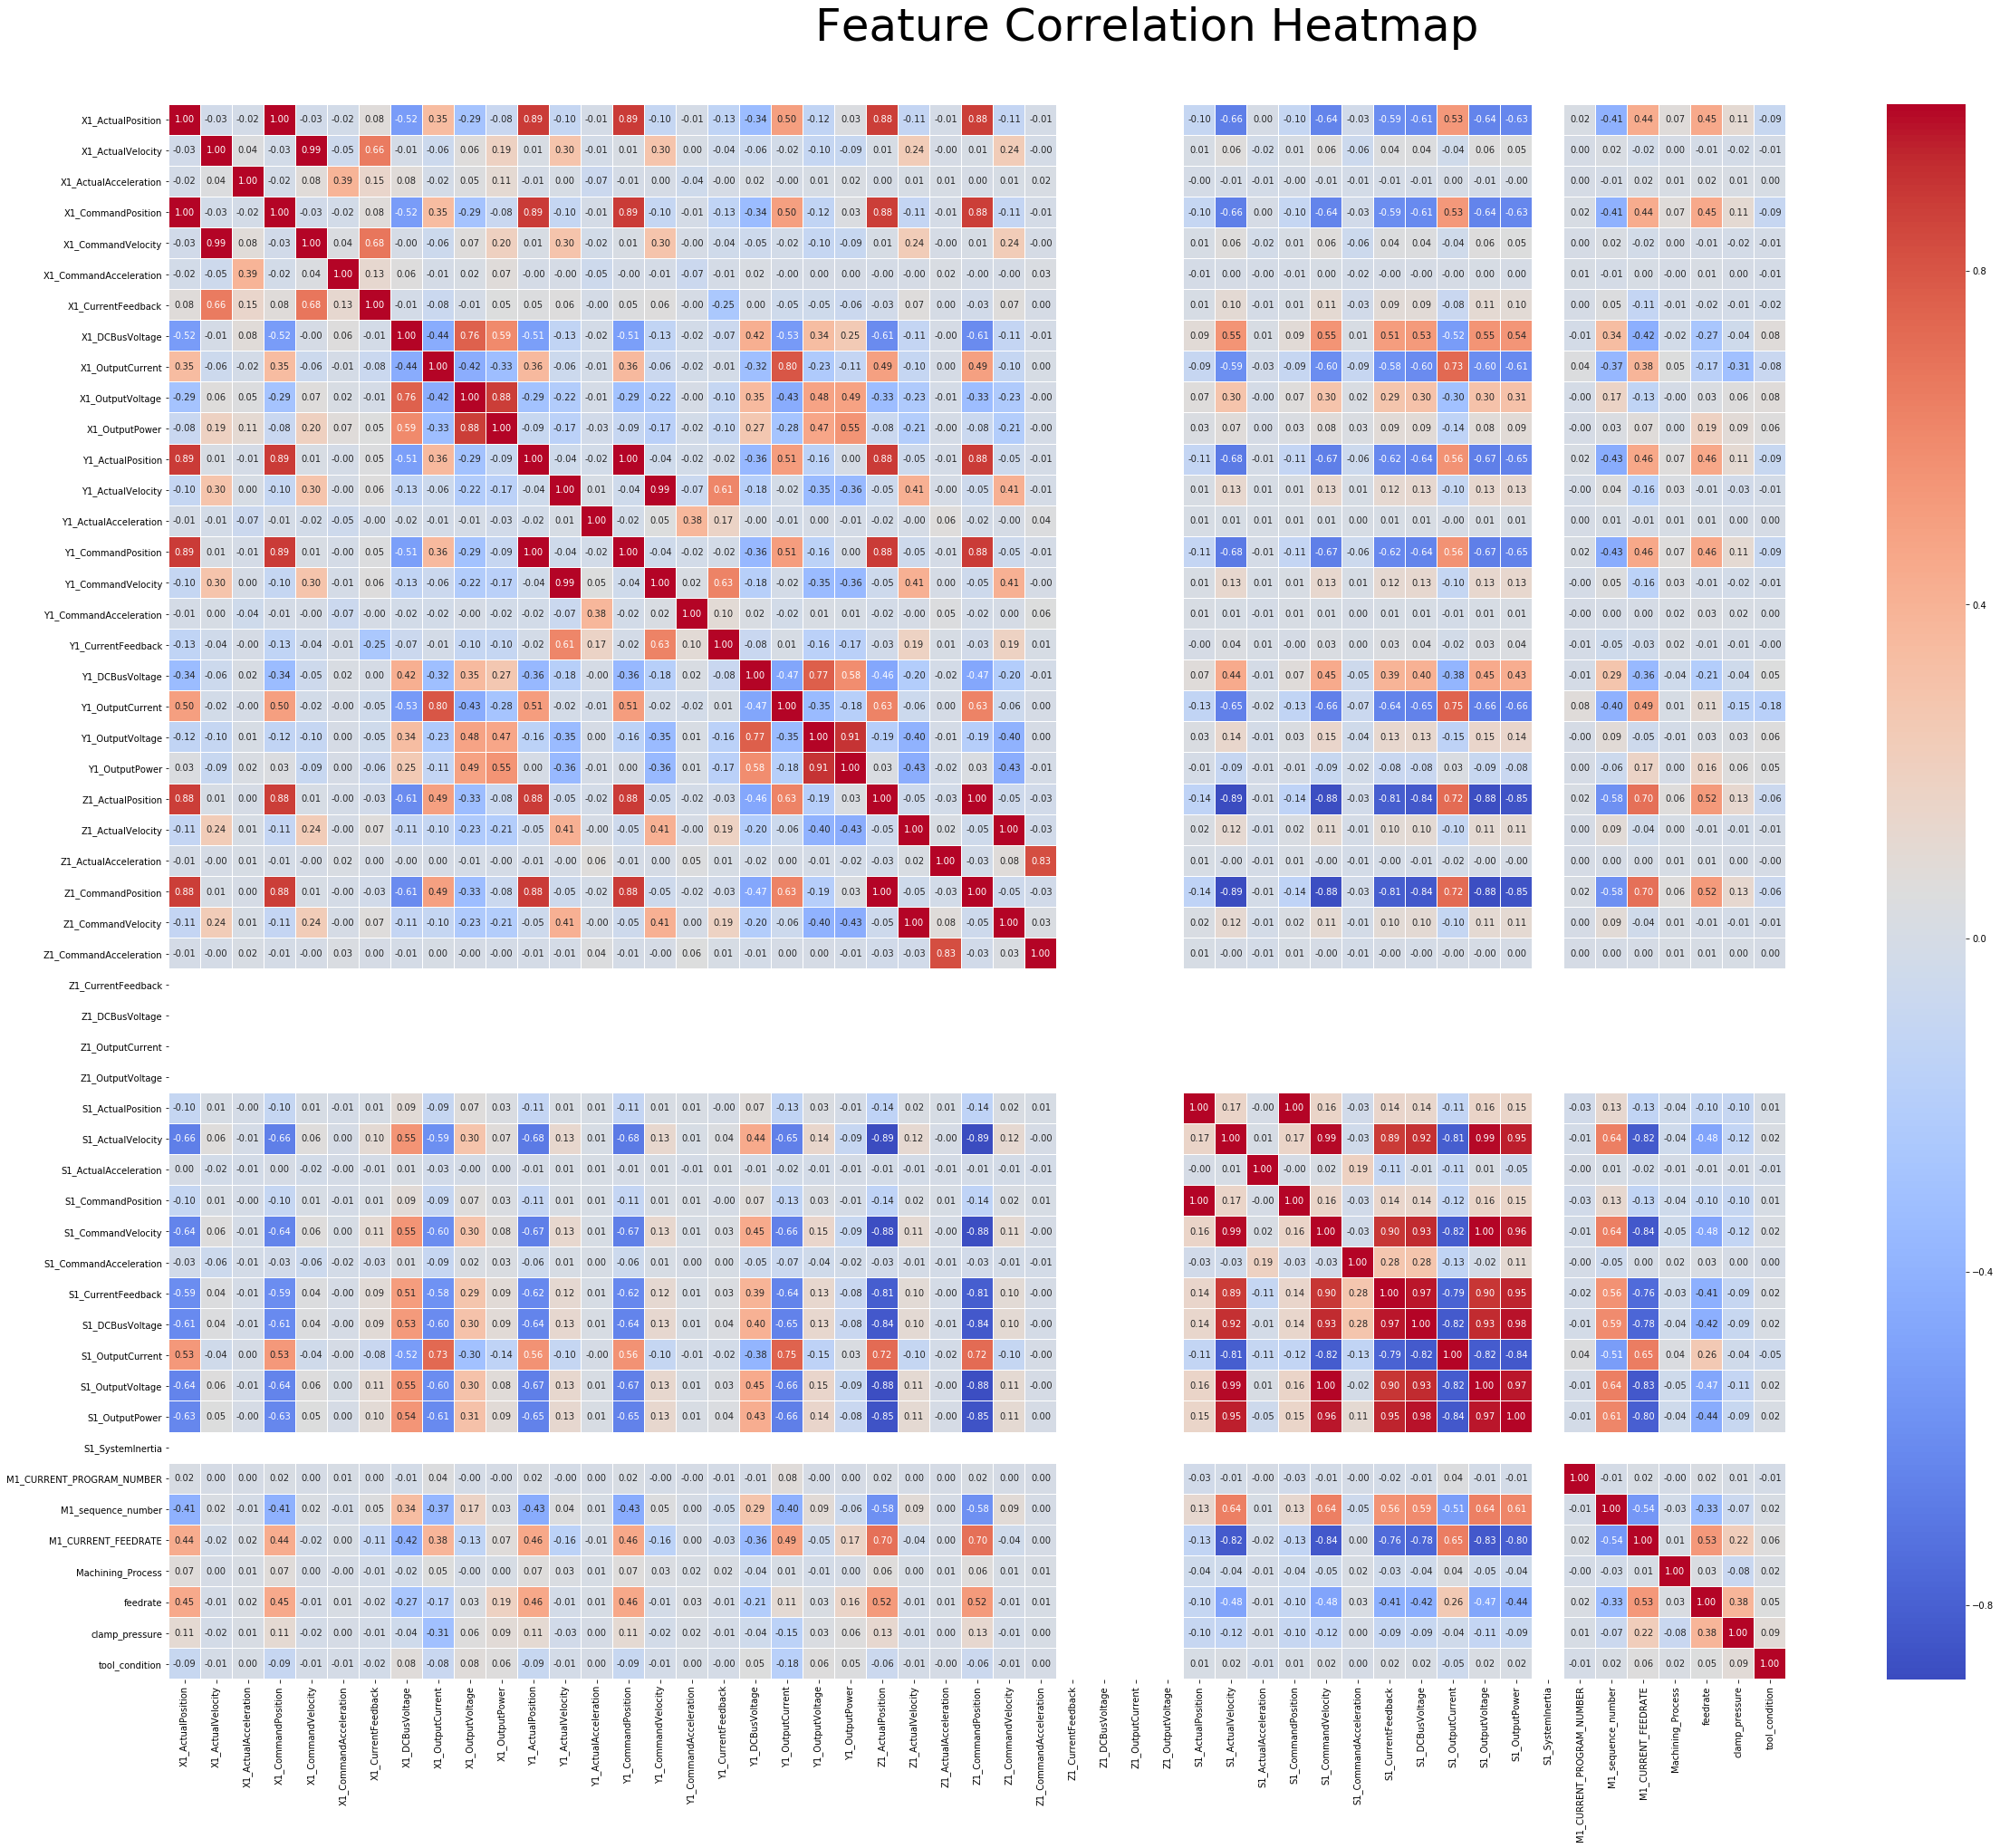

In [7]:
# visualizing relationship between features

correlated_data = data_frame.corr()

f, ax = plt.subplots(figsize=(40, 30))

hm = sns.heatmap(correlated_data, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)

t= f.suptitle('Feature Correlation Heatmap', fontsize=50)


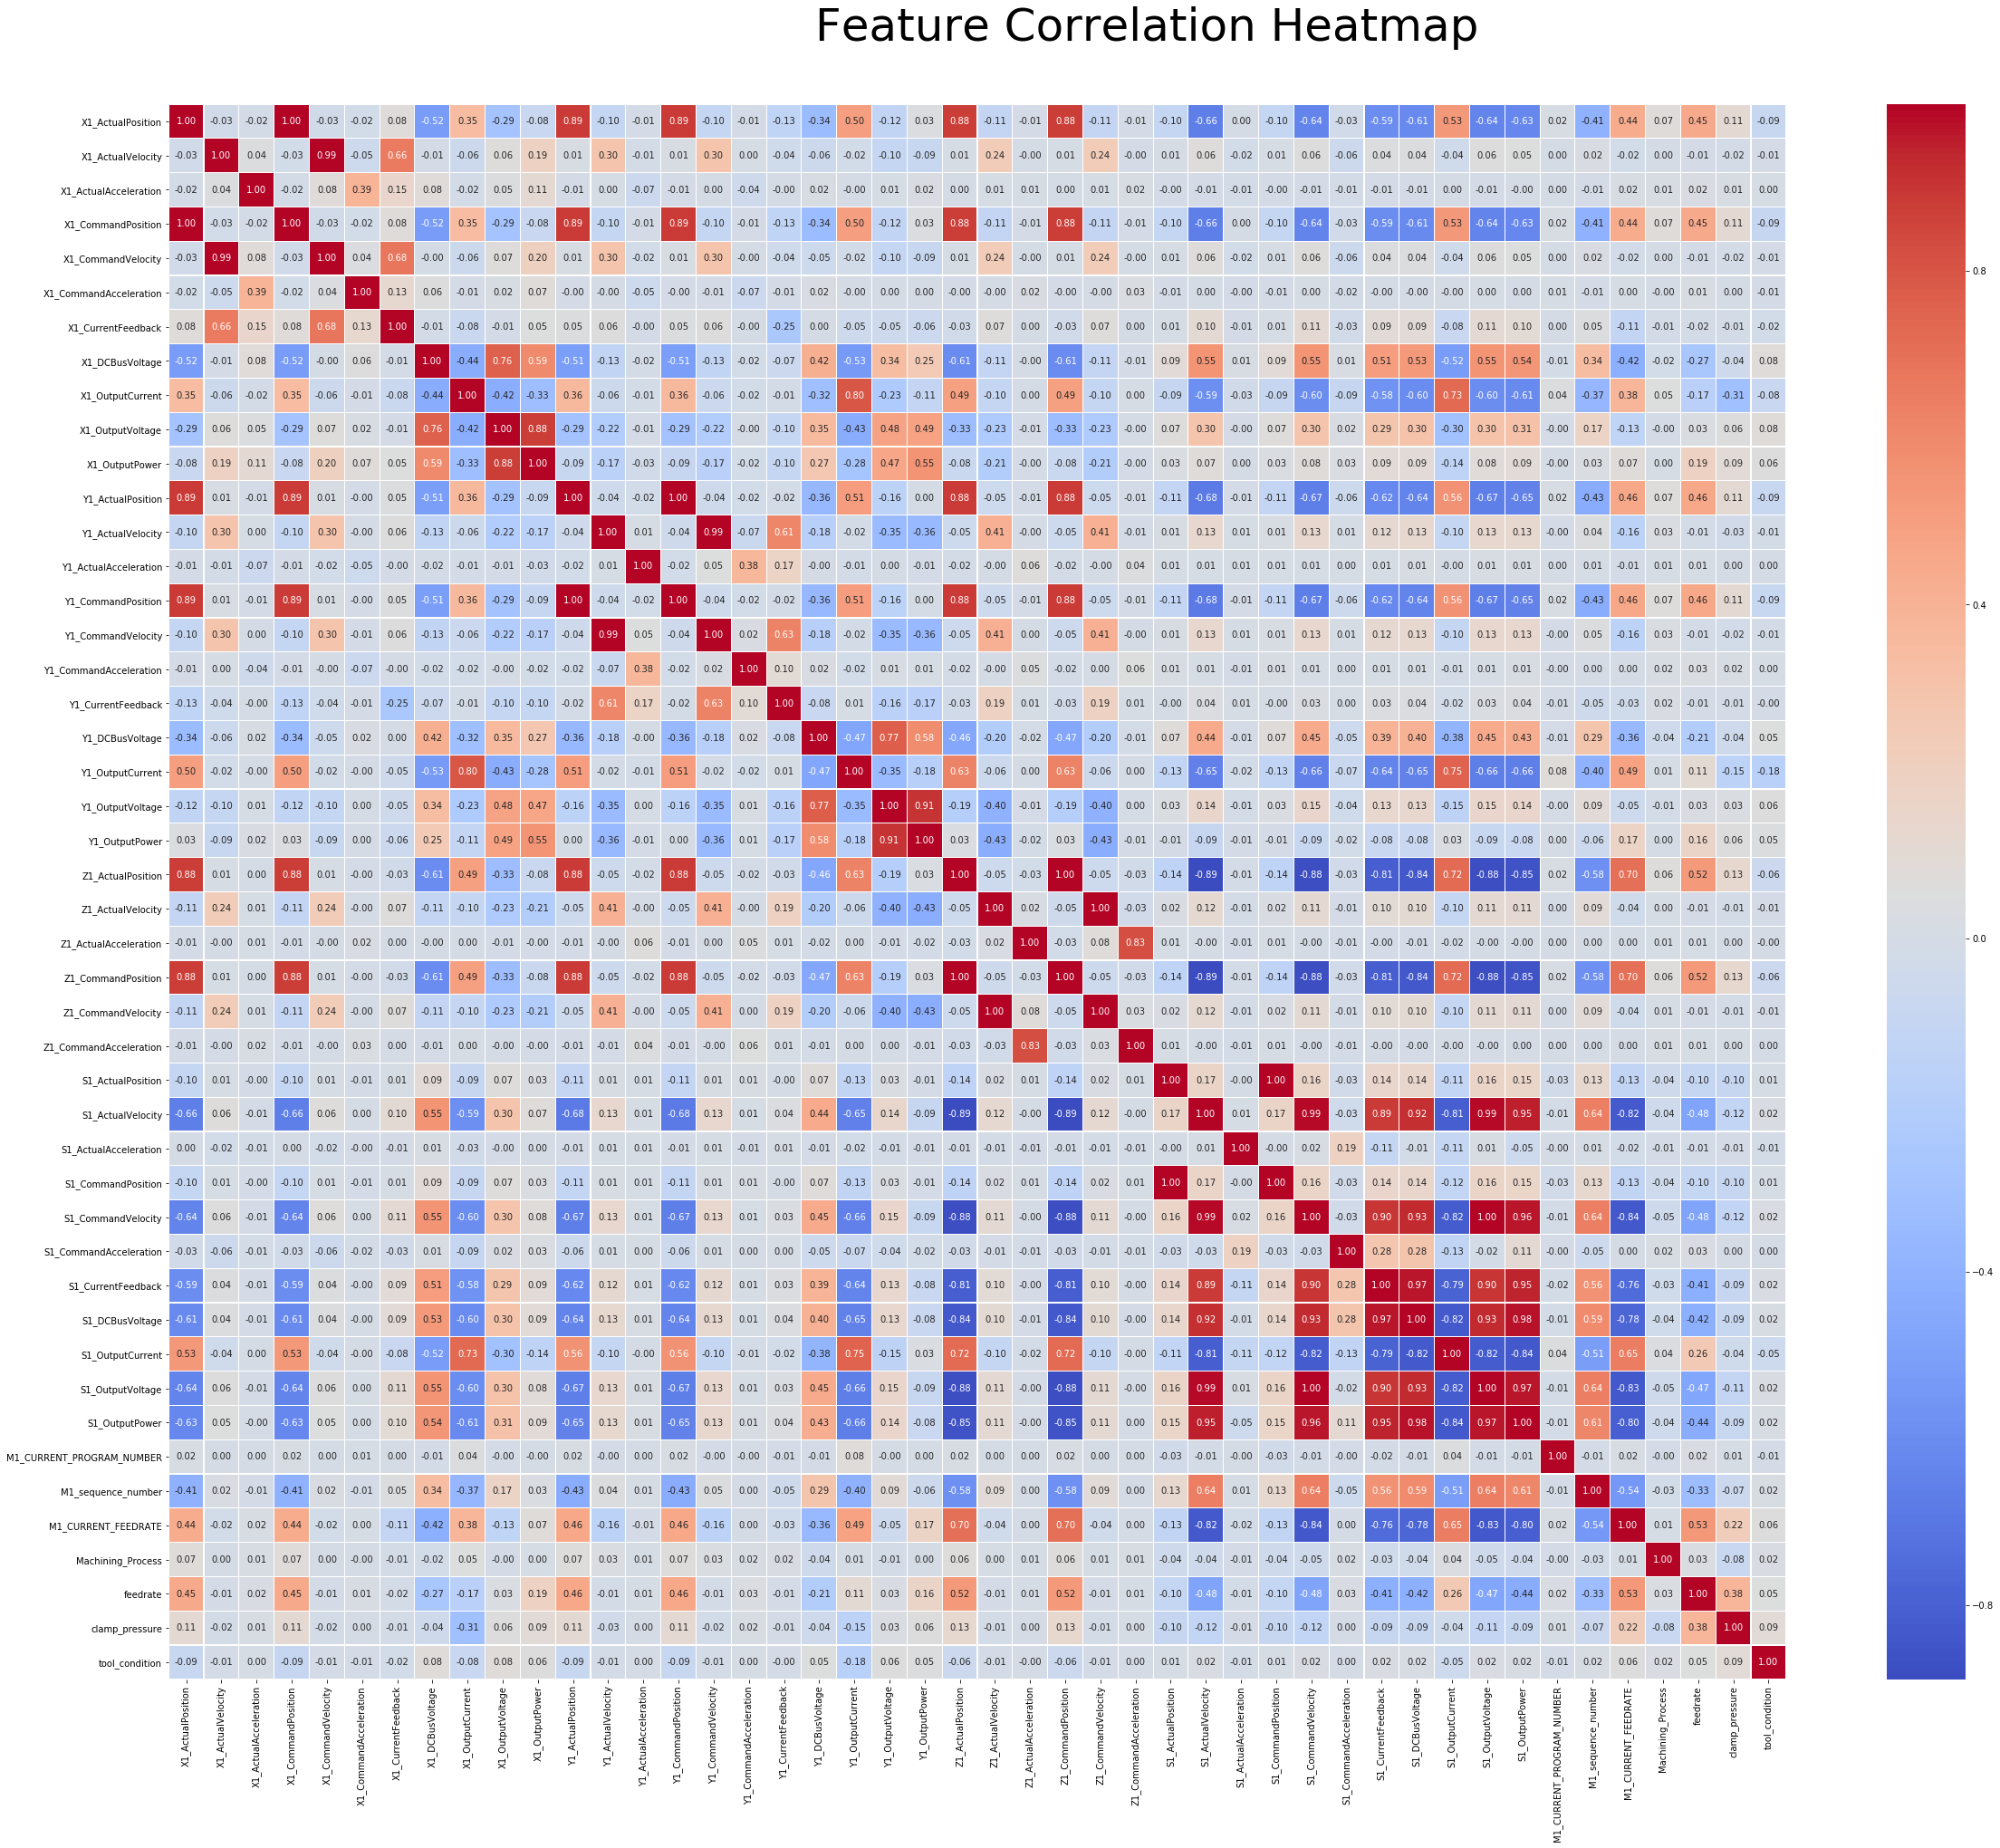

In [9]:
df = data_frame.drop(['Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent','Z1_OutputVoltage','S1_SystemInertia'],axis=1)

correlated_data = df.corr()
f, ax = plt.subplots(figsize=(40, 30))
hm = sns.heatmap(correlated_data, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Feature Correlation Heatmap', fontsize=50)


# Machine Learning model

In [10]:
X = df.drop(['tool_condition'],axis=1)
y = df['tool_condition']
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=42)

kf = model_selection.KFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print(X_train.shape, X_test.shape)

accuracy_list_algorithms = {}

(20229, 45) (5057, 45)


In [11]:
# Function to extract important features of a model
def imp_features(df, model):
    features = [(df.columns[i], v) for i,v in enumerate(model.feature_importances_)]
    features.sort(key=lambda x: x[1], reverse = True)
    for item in features[:10]:
        print("{0}: {1:0.4f}".format(item[0], item[1]))
    return features[:10]

# 1. Naive Bayes

In [12]:
%%time

classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)
confidence = classifier_NB.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')
accuracy_list_algorithms['Naive Bayes'] = confidence

55.82 %
CPU times: user 34.7 ms, sys: 522 µs, total: 35.2 ms
Wall time: 36.8 ms


Pros
* Easy and fast to predict the class

Cons
* Bad estimator compare to other classification algorithms

# 2. K nearest Neighbor classifier

In [13]:
%%time

classifier_KNeighbor = neighbors.KNeighborsClassifier()
classifier_KNeighbor.fit(X_train, y_train)
confidence = classifier_KNeighbor.score(X_test, y_test)

print("%.2f" % (confidence * 100), '%')
accuracy_list_algorithms['Knn'] = confidence


76.86 %
CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.36 s


Pros
* Simplest classification algorithm
* Non-parametric 
* High accuracy

Cons
* Stores all training data
* HIgh memory requirement

# 3. Support Vector machine

In [15]:
%%time

classifier_svm = svm.SVC(gamma='auto')
classifier_svm.fit(X_train, y_train)
confidence = classifier_svm.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')

accuracy_list_algorithms['Support Vector machine'] = confidence


63.87 %
CPU times: user 1min 54s, sys: 283 ms, total: 1min 54s
Wall time: 1min 54s


Pros

* effective for higher dimension
* outliers has less impact

Cons
* More time to process took 4 min while training for one instance


# 4. Stochastic gradient descent

In [16]:
%%time

# Quick but very fast to train

classifier_sgd = SGDClassifier()
classifier_sgd.fit(X_train, y_train)
confidence = classifier_sgd.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')

accuracy_list_algorithms['Stochastic gradient descent'] = confidence


52.36 %
CPU times: user 1.07 s, sys: 4.3 ms, total: 1.08 s
Wall time: 1.07 s


Pros
* In gerneral better with noisy data since it samples examples to compute gradient

Cons
* Common learning rate

# 5. Linear Discriminant Analysis

In [18]:
%%time

classifier_lda = LinearDiscriminantAnalysis()
classifier_lda.fit(X_train, y_train)
confidence = classifier_lda.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')

accuracy_list_algorithms['Linear Discriminant Analysis'] = confidence


60.83 %
CPU times: user 347 ms, sys: 36 ms, total: 383 ms
Wall time: 194 ms


* Reduces number of dimensions in a dataset while retaining as much as information

# 6. Quadratic Discriminant Analysis

In [19]:
%%time 

classifier_qda = QuadraticDiscriminantAnalysis()
classifier_qda.fit(X_train, y_train)
confidence = classifier_qda.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')

accuracy_list_algorithms['Quadratic Discriminant Analysis'] = confidence


57.25 %
CPU times: user 292 ms, sys: 68.1 ms, total: 360 ms
Wall time: 139 ms


/home/vaishu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


* Comparitively low accuracy

# 7. Random Forest Classifier


In [20]:
%%time 

classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
confidence = classifier_rf.score(X_test, y_test)
print("%.2f" % (confidence * 100), '%')

accuracy_list_algorithms['Random Forest Classifier'] = confidence

imp_feature_data = imp_features(df, classifier_rf)

imp_feature_data

/home/vaishu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


99.19 %
Z1_CommandPosition: 0.2547
Z1_ActualPosition: 0.1968
X1_OutputCurrent: 0.0591
S1_ActualPosition: 0.0452
M1_sequence_number: 0.0425
S1_CommandPosition: 0.0405
S1_OutputCurrent: 0.0400
Y1_OutputCurrent: 0.0256
M1_CURRENT_FEEDRATE: 0.0214
clamp_pressure: 0.0190
CPU times: user 410 ms, sys: 69 µs, total: 410 ms
Wall time: 413 ms


Pros
* Handles missing values and maintains accuracy for missing data.
* Handles large data with higher dimensionality

Cons
* If the data contain groups of correlated features of similar relevance for the output, then smaller groups are favored over larger groups.

In [21]:
li = sorted(accuracy_list_algorithms.items(), key=lambda x: x[1])
for item in li:
    print(item)

('Stochastic gradient descent', 0.52363061103421)
('Naive Bayes', 0.5582361083646431)
('Quadratic Discriminant Analysis', 0.5724737986948784)
('Linear Discriminant Analysis', 0.6082657702194977)
('Support Vector machine', 0.6387186078702788)
('Knn', 0.7686375321336761)
('Random Forest Classifier', 0.9918924263397271)
